In [117]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving an homogeneous elastic perforated plate. It is subjected to uniform normal traction imder a plane-stress condition. By symmetry, only one quarter of the plate is modelled.

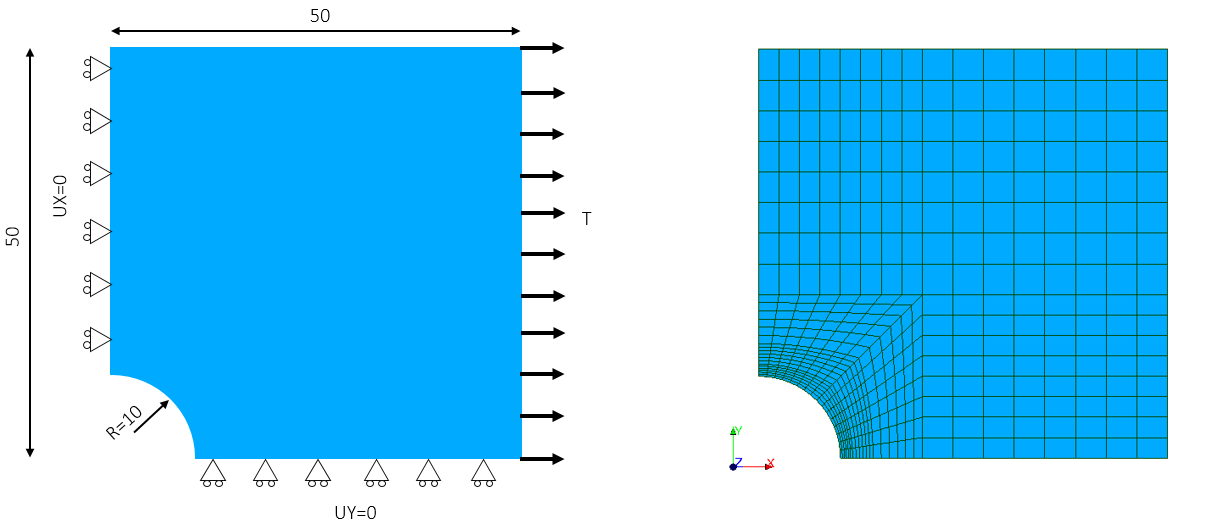

### General Libraries

In [118]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [119]:
from mesh_utils import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './PerforatedPlate.med')

Loaded SALOME .med mesh: 531 nodes, 630 elements
Node groups (4): ['left', 'right', 'top', 'bottom']
Element groups (6): ['all', 'right_s', 'bottom_e', 'top_e', 'right_e', 'left_e']


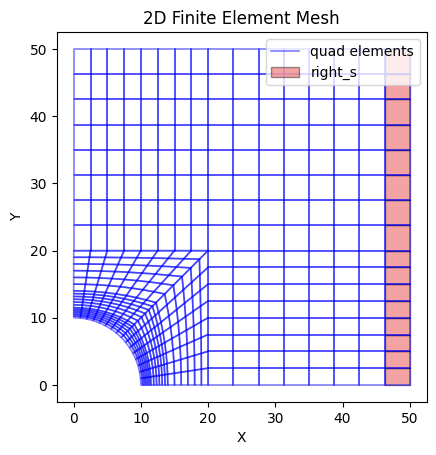

In [120]:
mesh.plot(show_nodes=False, element_groups_to_plot=['right_s'])

### Dirichlet boundary conditions

In [121]:
from feinn_solver import BoundaryCondition

bcs = {
        'left': BoundaryCondition(dof=1, value=0.0),
        'bottom': BoundaryCondition(dof=2, value=0.0),                
        }

### Define material

In [122]:
from matmodels import LinearElasticPlaneStress

steel = LinearElasticPlaneStress(emod = 20*1e-2, nu = 0.25)

matfield = {'all': steel}

### von Neumman boundary conditions

In [123]:
from feinn_solver import LineLoad

traction = {
            'right_e': LineLoad(fx = 1.0*1e-2, fy = 0, reference = "global"),
            }


### Model

In [124]:
from feinn_solver import NFEA

thickness = {
            'all': 1.0
                }

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      thickness = thickness,
                      line_loads = traction,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 630 elements have assigned material
[thickness] Applied 1 thickness groups
[line_load] Applied 1 line load groups
[BC] Processed 2 Dirichlet condition(s) → 54 total constraint(s)
[BC] Applied Dirichlet BCs → 54 fixed DOFs


In [125]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 3.37e-14  Energetic error: -1.61e-14
Iter   2 | du error: 3.80e-14  Res error: 9.53e-15  Energetic error: -2.29e-30
Converged in 2 iterations


In [126]:
fem_solver.udisp

tensor([ 1.6802,  0.0000,  1.8147,  ..., -0.6384,  0.1596, -0.6501])

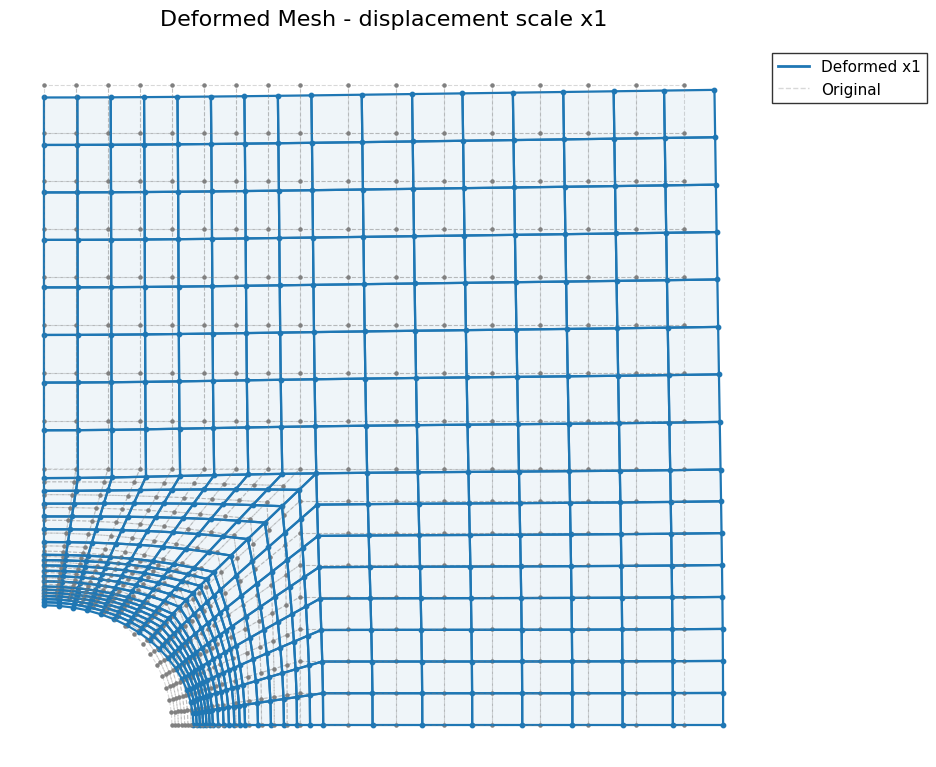

In [129]:
fem_solver.plot_deformed_mesh(scale=1)

In [132]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    thickness = thickness,
    line_loads = traction,
    verbose=False,
    nnet = mFCNet(),
    bc_weight=1e6,
    nnet_init = 'xavier',
    )